In [1]:
import numpyro
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi 
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
from jax import random

rng_key = random.PRNGKey(0)

5M1

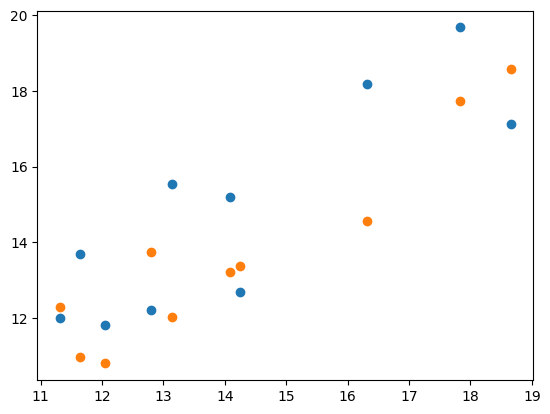

In [15]:
# simulate temperature data
N = 10
temperature = dist.Normal(15, 5).sample(rng_key, (N,))
# simulate ice cream sales data
icecream_sales = dist.Normal(temperature).sample(rng_key+1) + dist.Normal(0, 1).sample(rng_key+3, (N,))
# simulate shark attacks data
shark_attacks = dist.Normal(temperature).sample(rng_key+2) + dist.Normal(0, 1).sample(rng_key+4, (N,))

# plot the data
fig, ax = plt.subplots()
ax.scatter(temperature, icecream_sales, label='icecream sales')
ax.scatter(temperature, shark_attacks, label='shark attacks')

In [16]:
# numpyro model to model shark attacks from ice cream sales and temperature

def model_all(icecream_sales, temperature, shark_attacks=None):
    a = numpyro.sample('a', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + b1 * icecream_sales + b2 * temperature
    numpyro.sample('shark_attacks', dist.Normal(mu, sigma), obs=shark_attacks)

def model_temp(temperature, shark_attacks=None):
    a = numpyro.sample('a', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + b2 * temperature
    numpyro.sample('shark_attacks', dist.Normal(mu, sigma), obs=shark_attacks)

def model_ice(icecream_sales, shark_attacks=None):
    a = numpyro.sample('a', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + b1 * icecream_sales
    numpyro.sample('shark_attacks', dist.Normal(mu, sigma), obs=shark_attacks)

# numpyro inference for the model_all
guide_all = AutoLaplaceApproximation(model_all)
svi = SVI(model_all, guide_all, optim.Adam(0.1), Trace_ELBO(), icecream_sales=icecream_sales, temperature=temperature, shark_attacks=shark_attacks)
svi_result_all = svi.run(rng_key, 1000)

# numpyro inference for the model_temp
guide_temp = AutoLaplaceApproximation(model_temp)
svi = SVI(model_temp, guide_temp, optim.Adam(0.1), Trace_ELBO(), temperature=temperature, shark_attacks=shark_attacks)
svi_result_temp = svi.run(rng_key, 1000)

# numpyro inference for the model_ice
guide_ice = AutoLaplaceApproximation(model_ice)
svi = SVI(model_ice, guide_ice, optim.Adam(0.1), Trace_ELBO(), icecream_sales=icecream_sales, shark_attacks=shark_attacks)
svi_result_ice = svi.run(rng_key, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 2788.93it/s, init loss: 11869.3477, avg. loss [951-1000]: 23.4462]


/var/folders/j5/zd8npw6n33db23qmzf90zdmh0000gn/T/ipykernel_41926/2381916745.py:2: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  "model_all": guide_all.sample_posterior(


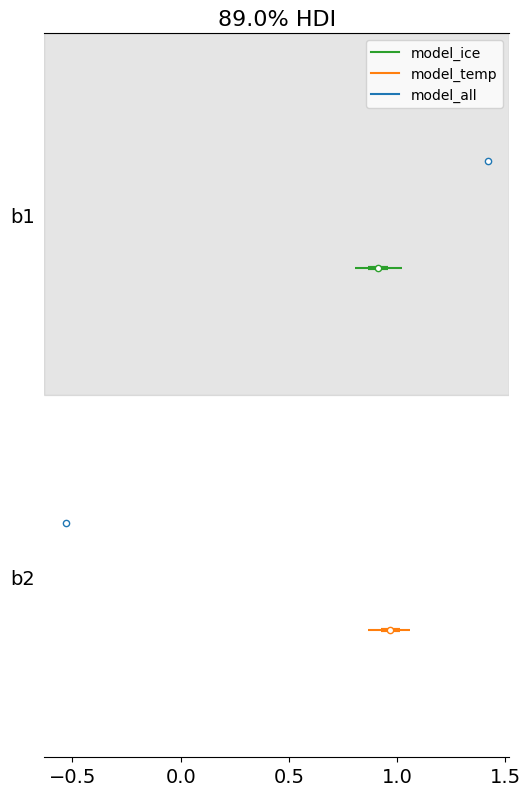

In [17]:
coeftab = {
    "model_all": guide_all.sample_posterior(
        random.PRNGKey(1),
        svi_result_all.params,
        (
            1,
            1000,
        ),
    ),
    "model_temp": guide_temp.sample_posterior(
        random.PRNGKey(2),
        svi_result_temp.params,
        (
            1,
            1000,
        ),
    ),
    "model_ice": guide_ice.sample_posterior(
        random.PRNGKey(3),
        svi_result_ice.params,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["b1", "b2"],
    hdi_prob=0.89,
)
plt.show()